# Tutorial 2

In [1]:
import os
from math import log2

import numpy as np
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Reload local python files every 2 seconds

%load_ext autoreload
%autoreload 2

## Build Tree Classifier from Logic Function

### A and (not B)

In [3]:
RANDOM_STATE = 1234

In [4]:
X = np.array([
    [0, 0],
    [1, 0],
    [0, 1],
    [1, 1]])

y = np.array([0, 1, 0, 0])

In [5]:
model = DecisionTreeClassifier(criterion='entropy', random_state=RANDOM_STATE)
model.fit(X, y)

DecisionTreeClassifier(criterion='entropy', random_state=1234)

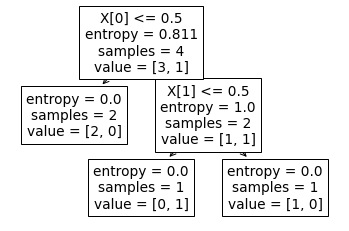

In [6]:
tree.plot_tree(model)
plt.savefig('plots/tree_logic_01.pdf', format='pdf', dpi=1200, bbox_inches='tight')

## Cross-Validation

We use the "yeast" dataset from last week.

In [7]:
PATH_YEAST_CLEAN = os.path.join('results', 'yeast.csv')
yeast = pd.read_csv(PATH_YEAST_CLEAN, sep=',')
yeast.head()

,Mcg,Gvh,Alm,Mit,Erl,Pox,Vac,Nuc,Class
0,0.58,0.61,0.47,0.13,0.5,0.0,0.48,0.22,0
1,0.43,0.67,0.48,0.27,0.5,0.0,0.53,0.22,0
2,0.64,0.62,0.49,0.15,0.5,0.0,0.53,0.22,0
3,0.58,0.44,0.57,0.13,0.5,0.0,0.54,0.22,1
4,0.42,0.44,0.48,0.54,0.5,0.0,0.48,0.22,0


In [8]:
# Split data 
y = yeast['Class'].to_numpy()
X = yeast.drop(['Class'], axis=1).to_numpy()

print(X.shape, y.shape)

(1484, 8) (1484,)


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
print(X_train.shape, X_test.shape)

(1187, 8) (297, 8)


### Appling CV on the training set

In [10]:
from sklearn.model_selection import cross_val_score

### Without CV (An overfitting example)

We allow the nodes to expand freely until all leaves are pure.

In [11]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion='entropy')
model.fit(X_train, y_train)

scores = model.score(X_train, y_train)
print('Acc on training set: {:.3f}'.format(scores))

scores = model.score(X_test, y_test)
print('Acc on test set:     {:.3f}'.format(scores))

print('Depth:', model.get_depth())

Acc on training set: 1.000
Acc on test set:     0.539
Depth: 21


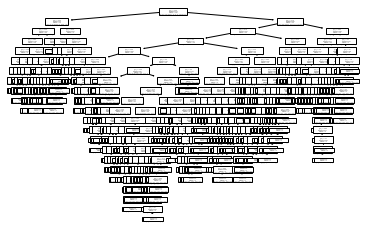

In [12]:
tree.plot_tree(model)
plt.show()

### Choosing between ``max_depth=5`` and ``max_depth=10``

In [13]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion='entropy', max_depth=5)
scores = cross_val_score(model, X_train, y_train, cv=5)
print(scores)
print('Score mean: {:.3f}, std: {:.3f}'.format(scores.mean(), scores.std()))

[0.57563025 0.5        0.55696203 0.57805907 0.5443038 ]
Score mean: 0.551, std: 0.028


C:\Users\Luke Chang\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


In [14]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion='entropy', max_depth=10)
scores = cross_val_score(model, X_train, y_train, cv=5)
print(scores)
print('Score mean: {:.3f}, std: {:.3f}'.format(scores.mean(), scores.std()))

[0.57142857 0.5        0.57383966 0.5443038  0.53164557]
Score mean: 0.544, std: 0.027


C:\Users\Luke Chang\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


### Training the model

Once we decide the hyperparameter, we train the model with the entire training set.

In a 5-folds CV, we do not want to lose 20% of the training data.

In [15]:
model = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion='entropy', max_depth=5)
model.fit(X_train, y_train)
score_test = model.score(X_test, y_test)
print('Acc on the test set:  {:.3f}'.format(score_test))

Acc on the test set:  0.593


### The simpler model works better in this case

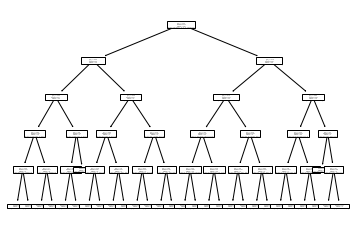

In [16]:
tree.plot_tree(model)
plt.show()

### Using ``GridSearchCV`` method to test multiple candidates at once

In [17]:
from sklearn.model_selection import GridSearchCV

Using 5-folds CV testing ``max_depth``$\in \{2, 3,...,20\}$

In [18]:
params = [{
    'max_depth': np.arange(2, 21), 
    'criterion': ['entropy']
}]
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
grid_search = GridSearchCV(dt, params, cv=5)
grid_search.fit(X_train, y_train)

C:\Users\Luke Chang\.conda\envs\venv\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1234),
             param_grid=[{'criterion': ['entropy'],
                          'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20])}])

In [19]:
# Indeed, the best max_depth is 5.
grid_search.best_estimator_

DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=1234)

## ROC and AUC

In [20]:
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score

In [21]:
# roc_curve only works on binary classification
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=284, random_state=RANDOM_STATE)

In [22]:
model = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=RANDOM_STATE)
model.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=1234)

In [23]:
proba = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, proba[:, 1])
auc_score = roc_auc_score(y_test, proba[:, 1])

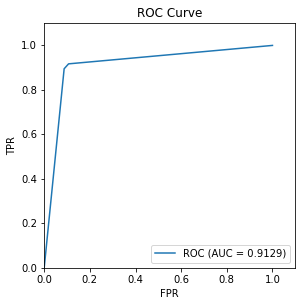

In [24]:
plt.figure(figsize=(4.5, 4.5))
plt.xlim(0., 1.1)
plt.ylim(0., 1.1)
plt.plot(fpr, tpr, label='ROC (AUC = %0.4f)' % auc_score)
plt.legend(loc='lower right')
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

## Autorank and Nemenyi test

Simplify the comparison between (multiple) paired populations. 

This module picks the correct test for you based on the data.

- Paired t-test
- The Wilcoxon signed rank test
- The Friedman test
- Repeated ANOVA 
- Tukey's HSD test

If the module is not installed, run ``python -m pip install autorank``

In [25]:
from autorank import autorank, create_report, plot_stats

In [26]:
np.random.seed(RANDOM_STATE)

std = 0.3
means = [0.6, 0.85, 0.9]
sample_size = 20  # Repeat the experiment 20 times
df = pd.DataFrame()
for i, mean in enumerate(means):
    df['model_%i' % i] = np.random.normal(mean, std, sample_size).clip(0, 1)

df.head()

,model_0,model_1,model_2
0,0.741431,0.789206,0.922860
1,0.242707,0.653209,0.730066
2,1.000000,0.908026,0.910843
3,0.506204,1.000000,0.277507
4,0.383823,1.000000,0.974338


In [27]:
result = autorank(df, verbose=False)
print(result)

RankResult(rankdf=
         meanrank    median       mad  ci_lower ci_upper effect_size  \
model_1      1.70  0.929629  0.104332  0.709208      1.0         0.0   
model_2      1.75  0.897416   0.15209  0.479408      1.0    0.246997   
model_0      2.55  0.645718  0.353566  0.135928      1.0    1.089171   

          magnitude  
model_1  negligible  
model_2       small  
model_0       large  
pvalue=0.009403562551495099
cd=0.7411442768595896
omnibus=friedman
posthoc=nemenyi
all_normal=False
pvals_shapiro=[0.11548826843500137, 0.0003265207342337817, 0.0011479731183499098]
homoscedastic=False
pval_homogeneity=0.025901241341294127
homogeneity_test=levene
alpha=0.05
alpha_normality=0.016666666666666666
num_samples=20
posterior_matrix=
None
decision_matrix=
None
rope=None
rope_mode=None
effect_size=akinshin_gamma)


In [28]:
create_report(result)

The statistical analysis was conducted for 3 populations with 20 paired samples.
The family-wise significance level of the tests is alpha=0.050.
We rejected the null hypothesis that the population is normal for the populations model_2 (p=0.000) and model_0 (p=0.001). Therefore, we assume that not all populations are normal.
Because we have more than two populations and the populations and some of them are not normal, we use the non-parametric Friedman test as omnibus test to determine if there are any significant differences between the median values of the populations. We use the post-hoc Nemenyi test to infer which differences are significant. We report the median (MD), the median absolute deviation (MAD) and the mean rank (MR) among all populations over the samples. Differences between populations are significant, if the difference of the mean rank is greater than the critical distance CD=0.741 of the Nemenyi test.
We reject the null hypothesis (p=0.009) of the Friedman test that th

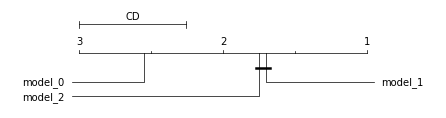

In [29]:
plot_stats(result)